In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [3]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_gauss_pairs_dataset, get_synthetic_dataset, get_simulated_pairs_dataset, get_multi_pairs_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [4]:
x, y, weight, target = get_gauss_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/gauss_pairs/files'
)

In [5]:
tf.config.list_physical_devices('GPU')

2022-08-12 14:46:04.242670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 14:46:04.253735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 14:46:04.253862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
wrong = [244]

In [20]:
def get_noise_elbo(input, output, num_inducing):
    # Need to find the ELBO for a noise model
    linear_kernel = gpflow.kernels.Linear(variance=1)
    kernel = linear_kernel

    Z = gpflow.inducing_variables.InducingPoints(
            np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
        )
    inducing_variable = Z

    reg_gp_model = gpflow.models.SGPR(data=(input, output), kernel=kernel, inducing_variable=inducing_variable)
    reg_gp_model.likelihood.variance = Parameter(
        1 + 1e-20, transform=positive(lower=1e-6)
    )
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        reg_gp_model.training_loss,
        reg_gp_model.trainable_variables,
        method="L-BFGS-B",
        options=dict(maxiter=200000),
    )
    loss = - reg_gp_model.elbo()
    return loss

Run number: 244


 15%|█▌        | 305/2000 [03:24<18:55,  1.49it/s]

Breaking as -365.5438904136635 is less than -363.3321833195271
Training everything


ELBO: -807.15763061824009 -363.33218331952708
target: [-1.]


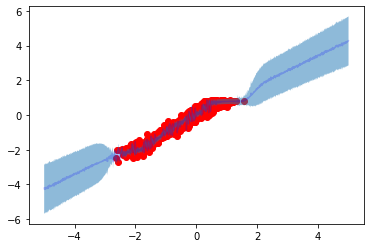

In [25]:
from gpflow.base import Parameter
from gpflow.utilities import positive
from sklearn.preprocessing import StandardScaler
import time
# tf.config.run_functions_eagerly(True)
from tqdm import trange


for i in wrong:
    print(f"Run number: {i}")
    if target[i] > 0:
        input = x[i]
        output = y[i]
    else:
        input = y[i]
        output = x[i]

    # input = np.linspace(1, 100, 100)[:, None]
    # output = input ** 2 + np.random.randn(100)[:, None]

    # print("Data created")

    input = StandardScaler().fit_transform(input).astype(np.float64)
    output = StandardScaler().fit_transform(output).astype(np.float64) 

    kernel_variance = 1.0
    # Likelihood variance
    kappa = np.random.uniform(
        low=10.0, high=100, size=[1]
    )
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1.0, high=100, size=[1]
    )

    latent_dim = 1
    num_inducing = 200

    kernel_lengthscale = 1. / lamda
    likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-6))

    kernel_lengthscale = 0.05
    likelihood_variance = 0.01

    # print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")


    noise_loss = get_noise_elbo(
        input=input,
        output=output,
        num_inducing=num_inducing
    )

    # Put in new values of hyperparams
    # X_mean_init = output - reg_gp_model.predict_y(input)[0]
    sq_exp = gpflow.kernels.SquaredExponential(
        lengthscales=[kernel_lengthscale] + [kernel_lengthscale / 3]
    )
    sq_exp.variance.assign(1)
    linear_kernel = gpflow.kernels.Linear(variance=1 + 1e-20)


    # sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale[0], kernel_lengthscale[1]])

    # linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    # poly_kernel = gpflow.kernels.Polynomial(degree=2, variance=kernel_variance)

    # sq_exp.variance.assign(kernel_variance)

    # quadratic_kernel = gpflow.kernels.Product([linear_kernel, linear_kernel_2])

    # kernel = poly_kernel
    kernel = gpflow.kernels.Sum([linear_kernel, sq_exp])
    # kernel_2 = gpflow.kernels.Sum([linear_kernel_2, sq_exp_2])
    # kernel = gpflow.kernels.SeparateIndependent(
    #     [
    #         kernel,  # This is k1, the kernel of f1
    #         kernel_2  # this is k2, the kernel of f2
    #     ]
    # )


    Z = gpflow.inducing_variables.InducingPoints(
        np.concatenate(
            [
                np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
                np.random.randn(num_inducing, 1),
            ],
            axis=1
        )
    )
    inducing_variable = Z
    # Z_2 = gpflow.inducing_variables.InducingPoints(
    #     np.concatenate(
    #         [
    #             np.linspace(input.min(), input.max(), num_inducing).reshape(-1, 1),
    #             np.random.randn(num_inducing, 1),
    #         ],
    #         axis=1
    #     )
    # )
    # inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    #     [
    #         Z,  # This is U1 = f1(Z1)
    #         Z_2,  # This is U2 = f2(Z2)
    #     ]
    # )
    X_mean_init = 0.01 * tf.cast(output, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (input.shape[0], latent_dim)), default_float()
    )

    m = PartObsBayesianGPLVM(
        data=output,
        in_data=input,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        inducing_variable=inducing_variable,
        jitter=1e-6
    )
    m.likelihood.variance = Parameter(
        likelihood_variance + 1e-20, transform=positive(lower=1e-6)
    )

    loss_fn = m.training_loss_closure()

    adam_vars = m.trainable_variables
    adam_opt = tf.optimizers.Adam(0.05)
    @tf.function
    def optimisation_step():
        adam_opt.minimize(loss_fn, adam_vars)

    # epochs = int(20e3)
    # log_freq = 100
    # with trange(1, epochs + 1) as pbar:
    #     losses = []
    #     for epoch in pbar:
    #         optimisation_step()
    #         if epoch % log_freq == 0:
    #             pbar.set_description(f"ELBO {- m.elbo()}")
    #         if epoch % 1000 == 0:
    #             obs_new = np.linspace(-5, 5, 1000)[:, None]

    #             Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
    #             Xnew = tf.cast(Xnew, dtype=default_float())
    #             Xnew = tf.concat(
    #                 [obs_new, Xnew], axis=1
    #             )
    #             pred_f_mean, pred_f_var = m.predict_y(
    #                 Xnew=Xnew,
    #             )
    #             plt.scatter(input[:, 0], output[:, 0], c='r')
    #             plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
    #             # plt.scatter(inducing_in, np.zeros(100) )
    #             plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
    #             plt.show()
    #             plt.close()
    #         losses.append(- m.elbo())
    #         if epoch > 101:
    #             losses.pop(0)
    #         if epoch > 1000 and np.abs(np.mean(losses[0:50]) - np.mean(losses[50:100])) < np.std(losses):
    #             print("BREAKING!")
    #             break                

    epochs = int(2e3)
    with trange(1, epochs + 1) as pbar:
        for epoch in pbar:
            optimisation_step()
            if - m.elbo() < noise_loss:
                print(f"Breaking as {- m.elbo()} is less than {noise_loss}")
                break


    # tf.print("ELBO:", - m.elbo())


    # Train everything
    # tf.print("Training everything")
    # gpflow.utilities.set_trainable(m.kernel, True)
    # gpflow.utilities.set_trainable(m.likelihood, False)
    # gpflow.utilities.set_trainable(m.X_data_mean , True)
    # gpflow.utilities.set_trainable(m.X_data_var, True)
    # gpflow.utilities.set_trainable(m.inducing_variable, True)
    # opt = gpflow.optimizers.Scipy()
    # opt_logs = opt.minimize(
    #     m.training_loss,
    #     m.trainable_variables,
    #     method="L-BFGS-B",
    #     options=dict(maxiter=200000),
    # )
    tf.print("Training everything")
    gpflow.utilities.set_trainable(m.kernel, True)
    gpflow.utilities.set_trainable(m.likelihood, True)
    gpflow.utilities.set_trainable(m.X_data_mean , True)
    gpflow.utilities.set_trainable(m.X_data_var, True)
    gpflow.utilities.set_trainable(m.inducing_variable, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=200000),
    )
    tf.print("ELBO:", - m.elbo(), noise_loss)

    tf.print(f"target: {target[i]}")
    loss = - m.elbo()

    obs_new = np.linspace(-5, 5, 1000)[:, None]

    Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
    Xnew = tf.cast(Xnew, dtype=default_float())
    Xnew = tf.concat(
        [obs_new, Xnew], axis=1
    )
    pred_f_mean, pred_f_var = m.predict_y(
        Xnew=Xnew,
    )
    plt.scatter(input[:, 0], output[:, 0], c='r')
    plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
    # plt.scatter(inducing_in, np.zeros(100) )
    plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
    plt.show()
    plt.close()


In [6]:
from models.BayesGPLVM import BayesianGPLVM


def get_marginal_noise_model_score(
    y: np.ndarray,
    num_inducing: int
):
    # Need to find the ELBO for a noise model
    linear_kernel = gpflow.kernels.Linear(variance=1)
    kernel = linear_kernel

    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, 1),
    )
    X_mean_init = 0.1 * tf.cast(y, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (y.shape[0], 1)), default_float()
    )
    x_prior_var = tf.ones((y.shape[0], 1), dtype=default_float())
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, 1),
    )
    # Define marginal model
    marginal_model = BayesianGPLVM(
        data=y,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        X_prior_var=x_prior_var,
        jitter=1e-6,
        inducing_variable=inducing_variable
    )
    marginal_model.likelihood.variance = Parameter(
        1, transform=positive(1e-6)
    )
    # Train everything
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        marginal_model.training_loss,
        marginal_model.trainable_variables,
        options=dict(maxiter=10000),
    )
    loss = - marginal_model.elbo()
    return loss

In [ ]:
def train_marginal_model(
    y: np.ndarray,
    num_inducing: int,
    kernel_variance: float,
    kernel_lengthscale: float,
    likelihood_variance: float,
    jitter: float,
):
    latent_dim = 1
    # Define kernel
    sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[kernel_lengthscale])
    sq_exp.variance.assign(kernel_variance)
    linear_kernel = gpflow.kernels.Linear(variance=kernel_variance)
    kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
    # Initialise approx posteroir and prior
    X_mean_init = 0.1 * tf.cast(y, default_float())
    X_var_init = tf.cast(
        np.random.uniform(0, 0.1, (y.shape[0], latent_dim)), default_float()
    )
    x_prior_var = tf.ones((y.shape[0], latent_dim), dtype=default_float())
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.random.randn(num_inducing, latent_dim),
    )

    # Define marginal model
    marginal_model = BayesianGPLVM(
        data=y,
        kernel=kernel,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        X_prior_var=x_prior_var,
        jitter=jitter,
        inducing_variable=inducing_variable
    )
    marginal_model.likelihood.variance = Parameter(
        likelihood_variance, transform=positive(1e-6)
    )

    # We will train the Adam until the elbo gets below the noise model score
    noise_elbo = get_marginal_noise_model_score(
        y=y,
        num_inducing=num_inducing
    )
    loss_fn = marginal_model.training_loss_closure()
    adam_vars = marginal_model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.05)
    @tf.function
    def optimisation_step():
        adam_opt.minimize(loss_fn, adam_vars)
    epochs = int(2e3)
    with trange(1, epochs + 1) as pbar:
        for epoch in pbar:
            optimisation_step()
            if - marginal_model.elbo() < noise_elbo:
                print(f"Breaking as {- marginal_model.elbo()} is less than {noise_elbo}")
                break

    # Train everything
    tf.print("Training everything")
    gpflow.utilities.set_trainable(marginal_model.kernel, True)
    gpflow.utilities.set_trainable(marginal_model.likelihood, True)
    gpflow.utilities.set_trainable(marginal_model.X_data_mean , True)
    gpflow.utilities.set_trainable(marginal_model.X_data_var, True)
    gpflow.utilities.set_trainable(marginal_model.inducing_variable, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        marginal_model.training_loss,
        marginal_model.trainable_variables,
        options=dict(maxiter=10000),
    )
    tf.print("ELBO:", - marginal_model.elbo())

    loss = - marginal_model.elbo()

    # Plot the fit to see if everything is ok
    obs_new = np.linspace(-5, 5, 1000)[:, None]

    pred_y_mean, pred_y_var = marginal_model.predict_y(
        Xnew=obs_new,
    )
    textstr = 'kern_len_lat=%.2f\nkern_var=%.2f\nlike_var=%.2f\nelbo=%.2f\n'%(
        marginal_model.kernel.kernels[0].lengthscales.numpy(),
        marginal_model.kernel.kernels[0].variance.numpy(),
        marginal_model.likelihood.variance.numpy(),
        - marginal_model.elbo().numpy()
    )
    plt.text(-8, 0, textstr, fontsize=8)
    plt.scatter(marginal_model.X_data_mean, y, c='r')
    plt.plot(obs_new, pred_y_mean, c='b', alpha=0.25)
    plt.fill_between(
        obs_new[:, 0],
        (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0],
        (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0],
        alpha=0.5
    )
    plt.show()
    plt.subplots_adjust(left=0.25)
    plt.close()
    return loss